# Assignment

In [7]:
import os
import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset
import time
import random 


In [2]:
device = None


## NN structures

In [15]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.5, num_filters = 1) -> None:
        super().__init__()
        self.features = nn.Sequential(
        nn.Conv2d(3, int(64*num_filters), kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(int(64*num_filters), int(192*num_filters), kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(int(192*num_filters), int(384*num_filters), kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(int(384*num_filters), int(256*num_filters), kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(int(256*num_filters), int(256*num_filters), kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )


        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(int(256*num_filters) * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        self.sigm = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        x = self.sigm(x)
        return x

def train(criterion, model, loader, optimizer, device=None):
    model.train()
    N = len(loader)
    for i, (images, labels) in enumerate(loader): 
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def eval_loss_and_error(criterion, model, loader, device=None):
    model.eval()
    l, accuracy, ndata = 0, 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            l += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            accuracy += pred.eq(target.view_as(pred)).sum().item()
            ndata += len(data)
    
    return l/ndata, accuracy/ndata*100

In [16]:
from torchvision import models
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True).to(device=device)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()
 
    def forward(self, x):
        return self.sigm(self.base_model(x))


In [18]:
# Initialize the model
model = Resnext50(19)
model = model.to(device)
# Switch model to the training mode
model.train()

Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

## Loading files

In [9]:
import re
import pandas as pd
from io import StringIO

FILENAME = 'train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [10]:
FILENAME = 'test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [11]:
x = torch.load("/Users/matteo/Documents/Università/Third_Year/Second_Semester/Deep_Learning/image_classification_with_caption/images_tensor_10000.pt")

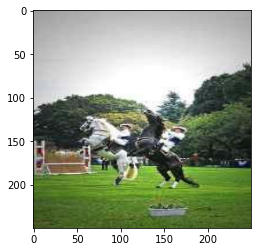

In [12]:
plt.imshow(x[1].permute(1, 2, 0))
plt.show()

The following code was used to create the df_train.csv file which we then we reload. 
We do not run it, as we already have the csv file.

In [98]:
"""
for i in range(df_train.shape[0]):
    df_train.Labels[i] = [int(j) for j in df_train.Labels[i].split()]

max_i = 0
for i in df_train.Labels:
    max_i = max(max_i, max(i))

min_i = 19
for i in df_train.Labels:
    min_i = min(min_i, min(i))
min_i

for i in range(1, max_i+1):
    df_train[f'{i}'] = 0

for i in range(df_train.shape[0]):
    for j in df_train.Labels[i]:
        df_train[f"{j}"][i] = 1

             
df_train.to_csv('df_train.csv')
"""

'\nfor i in range(df_train.shape[0]):\n    df_train.Labels[i] = [int(j) for j in df_train.Labels[i].split()]\n\nmax_i = 0\nfor i in df_train.Labels:\n    max_i = max(max_i, max(i))\n\nmin_i = 19\nfor i in df_train.Labels:\n    min_i = min(min_i, min(i))\nmin_i\n\nfor i in range(1, max_i+1):\n    df_train[f\'{i}\'] = 0\n\nfor i in range(df_train.shape[0]):\n    for j in df_train.Labels[i]:\n        df_train[f"{j}"][i] = 1\n\n             \ndf_train.to_csv(\'df_train.csv\')\n'

In [13]:
df_train = pd.read_csv('df_train.csv', index_col=0)
df_train.drop('12', inplace = True, axis=1)
df_train

,ImageID,Labels,Caption,1,2,3,4,5,6,7,...,9,10,11,13,14,15,16,17,18,19
0,0.jpg,[1],Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,"[1, 19]",A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,[1],They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,"[8, 3, 13]",a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,"[8, 3, 7]",A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29991,29995.jpg,"[8, 1, 2]",A picture of a truck that is in the middle of ...,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29992,29996.jpg,[1],A plate topped with a pizza being cut with a s...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29993,29997.jpg,[1],A man riding a snowboard on top of snow.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29994,29998.jpg,[1],This photo shows people skiing in the mountains.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_test

,ImageID,Caption
0,30000.jpg,A little girl waring a krispy kreme hat holdin...
1,30001.jpg,A beautiful young woman holding an orange fris...
2,30002.jpg,A group of people sitting on couch next to a c...
3,30003.jpg,A person on a snowboard rides on the hill.
4,30004.jpg,A man riding a skateboard with a helmet on in ...
...,...,...
9995,39995.jpg,A group of men riding surfboards riding a mass...
9996,39996.jpg,A motorcycle parked next to a car in a parking...
9997,39997.jpg,a little boy that is playing with a wii
9998,39998.jpg,group of kids play Frisbee golf in the middle ...


## DataLoader

In [105]:
class ImageDataset(Dataset):
    def __init__(self, images, csv, train, test):
        self.csv = csv # df_train
        self.train = train # boolean
        self.test = test # boolean
        self.images = images

        self.all_image_names = self.csv[:]['ImageID']
        self.captions = self.csv[:]['Caption']

        self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))

        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45)
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[:])
            self.labels = list(self.all_labels[:])
             # define the test transforms
            self.transform = transforms.Compose([
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = self.images[index]
        image = self.transform(image)
        targets = self.labels[index]
        caption = self.captions[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

In [106]:
train_data = ImageDataset(
    x, df_train, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    x, df_train, train=False, test=False
)

train_loader = DataLoader(
    train_data, 
    batch_size=32,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=32,
    shuffle=False
)

Number of training images: 25496
Number of validation images: 4500


In [109]:
model = AlexNet(num_classes=18).to(device=device)

In [110]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [111]:
for it in range(5):
    for i, data in enumerate(train_loader):
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # outputs_copy = torch.clone(outputs)
        # indeces = outputs_copy >= 0.5
        # indeces1 = outputs_copy < 0.5
        # outputs_copy[indeces] = 1
        # outputs_copy[indeces1] = 0
        print(i)
        # print((outputs_copy == target.to(None)).sum(axis=1) == len(outputs_copy[0]))
        # print(((outputs_copy == target.to(None)).sum(axis=1) == len(outputs_copy[0])).sum()/len(outputs_copy)*100)
        loss = criterion(outputs, target)
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()

IndexError: index 17124 is out of bounds for dimension 0 with size 10000

In [112]:
model.eval()
l, accuracy, ndata = 0, 0, 0
with torch.no_grad():
    for data in valid_loader:
        data, labels = data['image'].to(device), data['label'].to(device)
        output = model(data)
        accuracy += ((output >= 0.5) == labels).float().sum()
        print(accuracy)
        ndata += output.numel()
        
model(train_data[0])

/var/folders/wh/3gql38352135mch4hpd4c2s80000gn/T/ipykernel_4320/1826327991.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


tensor(278.)
tensor(564.)
tensor(843.)
tensor(1121.)
tensor(1404.)
tensor(1689.)
tensor(1977.)
tensor(2258.)
tensor(2546.)
tensor(2831.)
tensor(3107.)
tensor(3382.)
tensor(3661.)
tensor(3952.)
tensor(4237.)
tensor(4522.)
tensor(4807.)
tensor(5096.)
tensor(5370.)
tensor(5662.)
tensor(5946.)
tensor(6236.)
tensor(6514.)
tensor(6810.)
tensor(7099.)
tensor(7389.)
tensor(7665.)
tensor(7949.)
tensor(8244.)
tensor(8528.)
tensor(8802.)
tensor(9085.)
tensor(9374.)
tensor(9655.)
tensor(9939.)
tensor(10231.)
tensor(10507.)
tensor(10779.)
tensor(11051.)
tensor(11332.)
tensor(11623.)
tensor(11912.)
tensor(12200.)
tensor(12481.)
tensor(12762.)
tensor(13034.)
tensor(13314.)
tensor(13593.)
tensor(13862.)
tensor(14141.)
tensor(14425.)
tensor(14704.)
tensor(14997.)
tensor(15282.)
tensor(15567.)
tensor(15858.)
tensor(16139.)
tensor(16432.)
tensor(16705.)
tensor(16985.)
tensor(17268.)
tensor(17552.)
tensor(17831.)
tensor(18125.)
tensor(18407.)
tensor(18685.)
tensor(18963.)
tensor(19244.)
tensor(19525.)
ten

TypeError: conv2d() received an invalid combination of arguments - got (dict, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!dict!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!dict!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [113]:
for i, data in enumerate(valid_loader):
    data, target = data['image'].to(None), data['label'].to(None)
    outputs = model(data)
    outputs_copy = torch.clone(outputs)
    indeces = outputs_copy >= 0.5
    indeces1 = outputs_copy < 0.5
    outputs_copy[indeces] = 1
    outputs_copy[indeces1] = 0
    print(i)
    print((outputs_copy == target.to(None)).sum(axis=1) == len(outputs_copy[0]))

    print(((outputs_copy == target.to(None)).sum(axis=1) == len(outputs_copy[0])).sum()/len(outputs_copy)*100)
    

/var/folders/wh/3gql38352135mch4hpd4c2s80000gn/T/ipykernel_4320/1826327991.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
tensor(0.)
1
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
tensor(0.)
2
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
tensor(0.)
3
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, Fal

In [19]:
df= pd.DataFrame()


""


In [115]:
from sklearn.metrics import f1_score

def metrics(predictions, targets, threshold = 0.5):
    pred_labels = []
    for init_pred in predictions:
        #if there are no elements set to one just set the highest to 1
        if sum(init_pred > threshold) == 0:
            #initialize an array of zeros
            var = np.zeros(18)
            var[np.argmax(init_pred[1])] = 1
            pred_labels.append(var)
        else: 
            pred_labels.append(np.array(init_pred > threshold, dtype=float))
    
    predictions = np.array(pred_labels, dtype=float)
    
    return {'f1_score' : f1_score(targets, predictions, average = 'samples')
            }

In [124]:
train_data['labels']

IndexError: too many indices for tensor of dimension 4

In [118]:
y_pred = model(train_loader)
(y_pred >= 0.5).type(torch.uint8)
targets = train_loader['labels']
metrics(y_pred, targets)

TypeError: conv2d() received an invalid combination of arguments - got (DataLoader, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!DataLoader!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!DataLoader!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [78]:
#4790
l = []
for i in range(len(df_train['Caption'])):
    if "?" in df_train['Caption'][i]:
        l.append(i+1)



l , df_train['Caption'][5325]

([5326, 10750, 24536, 27767, 28048, 28986, 29434],
 'Is he attempting to drill a hole on the baseball field?')

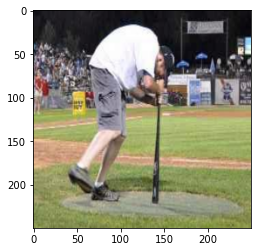

In [79]:
plt.imshow(x[5326].permute(1, 2, 0))
plt.show()

In [ ]:
for i, data in enumerate(valid_loader):
    data, target = data['image'].to(None), data['label'].to(None)
    outputs = model(data)
    outputs_copy = torch.clone(outputs)
    indeces = outputs_copy >= 0.5
    indeces1 = outputs_copy < 0.5
    outputs_copy[indeces] = 1
    outputs_copy[indeces1] = 0
    print(i)
    print((outputs_copy == target.to(None)).sum(axis=1) == len(outputs_copy[0]))
    print(((outputs_copy == target.to(None)).sum(axis=1) == len(outputs_copy[0])).sum()/len(outputs_copy)*100)

## Function

prediction(model, test_data)
and returns a dataset which we'll need to conver it to a csv file as specified by the assignment

In [ ]:
def prediction(model, test_data):
    
    df = pd.DataFrame()
    df['Labels'] = 
    df['ImageID'] = 
    return df